In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/EmilianoHFlores/segment-anything

fatal: destination path 'segment-anything' already exists and is not an empty directory.


In [3]:
%cd segment-anything/notebooks
import os
print(os.getcwd())
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/segment-anything/notebooks
/content/segment-anything/notebooks


In [4]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [5]:
# Model
model = torch.hub.load("ultralytics/yolov5", "yolov5m")  # or yolov5n - yolov5x6, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-19 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


In [9]:
# Images
#img = "data/images/zidane.jpg" # or file, Path, PIL, OpenCV, numpy, list
imgPath = "images/foto_desktop.jpeg"
%cd ..
%cd ..
imgPath = "/content/drive/"+"My Drive"+"/HOME2023/SAM_Models/prueba2.jpg"

img = cv2.imread(imgPath)
%cd segment-anything/notebooks

/content/segment-anything
/content
/content/segment-anything/notebooks


In [10]:
results = model(img)

Predicted bottle at [893.11, 4.67, 1733.83, 1455.31, 0.88] with confidence 39.00.
Predicted cup at [2223.28, 3.97, 2697.2, 560.2, 0.78] with confidence 41.00.
Predicted keyboard at [0.01, 632.66, 628.23, 975.92, 0.75] with confidence 66.00.
Predicted cup at [2731.44, 1077.57, 3311.5, 2092.15, 0.69] with confidence 41.00.
Predicted cup at [1750.74, 952.54, 2401.34, 1736.28, 0.69] with confidence 41.00.
Predicted tv at [653.49, 0.0, 1953.43, 430.54, 0.42] with confidence 62.00.


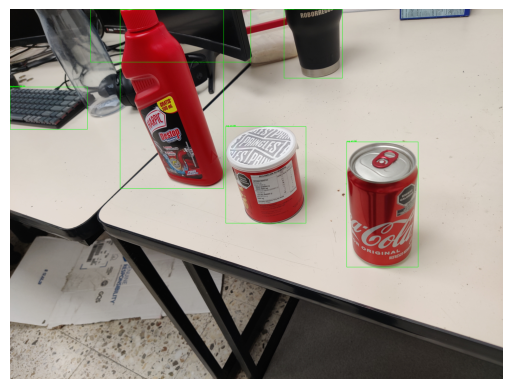

In [11]:
%matplotlib inline
# Results
showimg = img.copy()
for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
    print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
    showimg = cv2.rectangle(showimg, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
    showimg = cv2.putText(showimg, f"{cls} {conf:.2f}", (int(xyxy[0]), int(xyxy[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Visualize on matplotlib
plt.imshow(cv2.cvtColor(showimg, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_contour(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ax.imshow(mask_image)

In [14]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
sam_model = "h"

if sam_model =="h":
  sam_checkpoint = "/content/segment-anything/notebooks/sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = "/content/segment-anything/notebooks/sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [15]:
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

predictor.set_image(resized)

In [16]:
object = "keyboard"

image_bboxes = []
image_xywh = []

for *xyxy, conf, cls in results.pandas().xyxy[0].itertuples(index=False):
      print(f"Predicted {cls} at {[round(elem, 2) for elem in xyxy ]} with confidence {conf:.2f}.")
      image_bboxes.append(np.array([xyxy[0], xyxy[1], xyxy[2], xyxy[3]]))
      image_xywh.append([xyxy[0], xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]])

masks = []

for image_bbox in image_bboxes:
  mask, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=image_bbox,
      multimask_output=False,
  )
  masks.append(mask)

Predicted bottle at [893.11, 4.67, 1733.83, 1455.31, 0.88] with confidence 39.00.
Predicted cup at [2223.28, 3.97, 2697.2, 560.2, 0.78] with confidence 41.00.
Predicted keyboard at [0.01, 632.66, 628.23, 975.92, 0.75] with confidence 66.00.
Predicted cup at [2731.44, 1077.57, 3311.5, 2092.15, 0.69] with confidence 41.00.
Predicted cup at [1750.74, 952.54, 2401.34, 1736.28, 0.69] with confidence 41.00.
Predicted tv at [653.49, 0.0, 1953.43, 430.54, 0.42] with confidence 62.00.


drawing mask0
<class 'numpy.ndarray'>
drawing mask1
<class 'numpy.ndarray'>
drawing mask2
<class 'numpy.ndarray'>
drawing mask3
<class 'numpy.ndarray'>
drawing mask4
<class 'numpy.ndarray'>
drawing mask5
<class 'numpy.ndarray'>
(3000, 4000)


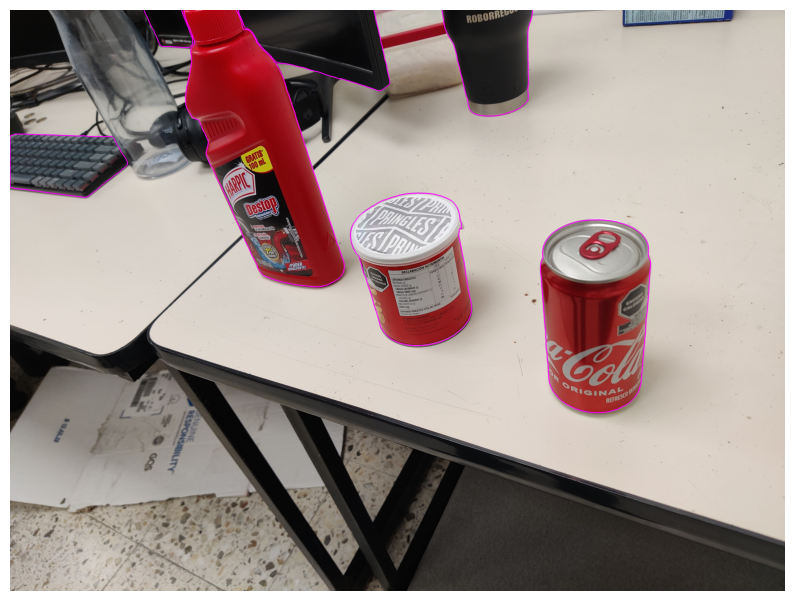

In [17]:
plt.figure(figsize=(10, 10))
showimg = resized.copy()

for i, mask in enumerate(masks):
  print(f"drawing mask{i}")
  print(type(mask[0]))
  contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(showimg, contours, -1, (255,0,255), 3)

plt.imshow(cv2.cvtColor(showimg, cv2.COLOR_BGR2RGB))

print(masks[0].shape[-2:])
plt.axis('off')
plt.show()

In [17]:
# Creating annotation in COCO format
#{"id": 0, "file_name": "0.jpg", "height": 480, "width": 736}
images=[]
annotations=[]
categories=[]

category_id = 0
category_name = "laptop"

image_0 ={"id": 0, "file_name": "0.jpg", "height": 480, "width": 736}

img_id=0
anno_id=0

annotations.append({"id": anno_id,"image_id": img_id,"category_id": 0,"bbox": image_bbox,"segmentation": segmentation,"area": polygon_area,"iscrowd": 0})

    for img in fg_imgs:
        fg_img=img[1]
        
        # Format the segmentation coordinates in COCO format
        segmentation = []
        aux_segmentation = []

        for contour in contours:
            polygon = contour.flatten().tolist()
            if len(polygon) % 2 != 0:
                print("Error: polygon has an odd number of coordinates")
                continue
            polygon = np.array(polygon).reshape((-1, 2))
            aux_segmentation.append(polygon)
        polygon_area = cv2.contourArea(aux_segmentation[0])
        for sublist in aux_segmentation[0]:
            for item in sublist:
                segmentation.append(item)


        # Calculate the maximum allowed position for the top-left corner
        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height
        max_area = fg_img.width * fg_img.height

            # Generate a random location until an unoccupied area is found that meets the overlap limit

        for i in range (10):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            # Calculate the overlap area
            overlap_area = np.sum(occupied[y:y+fg_img.height, x:x+fg_img.width])

            # Check if the area is unoccupied and the overlap limit is not exceeded
            if (max_overlap_area - max_area) >= np.sum(occupied):
                break
            if i==10:
                continue

        for i in range(0, len(segmentation)):
            if i % 2:
                i=i+x
            else :
                i=i+y
                
        # Update the occupied array
        occupied[y:y+fg_img.height, x:x+fg_img.width] = 1
        bg_img.paste(fg_img, (x, y), fg_img)
        annotations.append({"id": anno_id,"image_id": img_id,"category_id": annotations_dict[img[0]],"bbox": [x, y, fg_img.width, fg_img.height],"segmentation": segmentation,"area": polygon_area,"iscrowd": 0})
        anno_id=anno_id+1
        #draw = ImageDraw.Draw(bg_img)
        #draw.rectangle((x, y, x+fg_img.width, y+fg_img.height), outline='red', width=3)
    bg_img.save(str(img_id)+".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id)+".jpg","height": bg_img.height,"width": bg_img.width})
    img_id=img_id+1

IndentationError: ignored

In [ ]:
# Define the COCO dictionary
coco_dict = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}